<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

import matplotlib.pyplot as plt
import seaborn as sns
# Display plots in this notebook, instead of externally. 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline

In [2]:
data=pd.read_csv("amazon_reviews.csv")

In [3]:
data.shape

(10000, 2)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
text     10000 non-null object
label    10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB


In [5]:
data.label.value_counts()

__label__1     5097
__label__2     4903
Name: label, dtype: int64

In [6]:
#Checking if any observation is duplicated
data.duplicated().sum()

0

In [7]:
import re, nltk,regex
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import itertools
from bs4 import BeautifulSoup
from yellowbrick.text import FreqDistVisualizer
import logging
import gensim

import spacy
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import textblob
from textblob import TextBlob
#spacy.prefer_gpu()
nlp =spacy.load('en_core_web_lg')
from spacy import displacy
import textacy

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [8]:
print(data['text'].apply(lambda x: len(x.split(' '))).sum())

805532


In [9]:
def print_plot(index):
    example = data[data.index == index][['text', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Sentiment:', example[1])

In [10]:
print_plot(113)

 Hours of Fun for my 4 and 6 year olds: We purchased this game a year ago and my girls still love to play it. Lot's of activities, they love to decorate the floats and watch the parade.
Sentiment: __label__2 


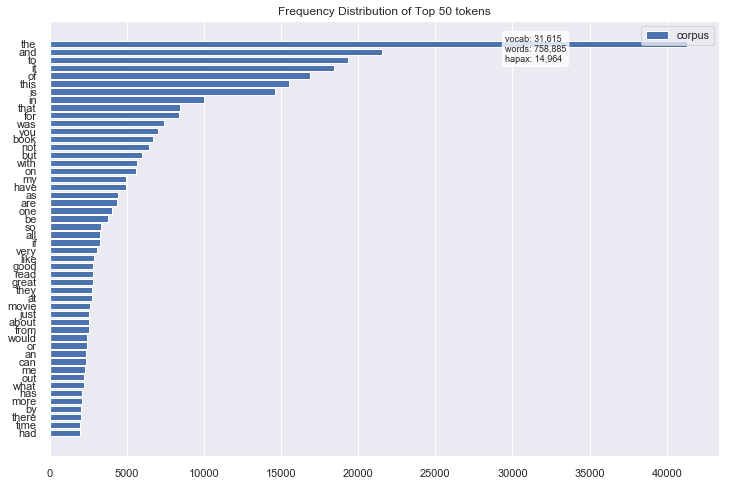

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(data['text'])
features   = vectorizer.get_feature_names()
plt.figure(figsize=(12,8))
sns.set(font_scale=1)
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
for label in visualizer.ax.texts:
    label.set_size(20)
visualizer.poof()

In [12]:
((data['text'].apply(lambda x:re.findall(r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?", x))).sort_values(ascending=False)).head(6)

1797                        [(http, www.sortaweb.com, /)]
4755                 [(http, www.redchairsoftware.com, )]
9376    [(http, www.launch.com, /music/artistpage/1,43...
436             [(http, www.jfk-info.com, /sitemap1.htm)]
5804               [(http, www.certificationguide.com, )]
1873    [(http, www.amazon.com, /gp/product/B00005YVX9...
Name: text, dtype: object

In [13]:
data['text']=data['text'].apply(lambda x:re.sub(r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?","", x))# replacing url strings with ""

In [14]:
data['text'][436]

' See my article "Jean Hill - The Lady in Red" online: Since writing my review of JFK: THE LAST DISSENTING WITNESS in 1998, I have been able to have my 35-page article - "Jean Hill -The Lady in Red" - included in Clint Bradford\'s JFK Assassination website. The address is:  (scroll down for title).'

In [15]:
#Finding reviews where fullstop is used continuously
(data['text'].apply(lambda x:re.findall("(\.+)$", x))).sort_values(ascending=False)

1250    [........................]
8662                [............]
8685                 [...........]
6096                  [..........]
3375                     [.......]
2303                     [.......]
4463                     [.......]
413                      [.......]
5998                     [.......]
6464                      [......]
3971                      [......]
4313                      [......]
2221                      [......]
4100                      [......]
6725                      [......]
5503                      [......]
8367                       [.....]
785                        [.....]
8667                       [.....]
8199                       [.....]
2343                       [.....]
9346                       [.....]
2514                       [.....]
8508                       [.....]
7896                       [.....]
7997                       [.....]
3723                        [....]
7604                        [....]
7688                

In [16]:
#Replacing strings like "....." with "."
data['text']=data['text'].apply(lambda x:re.sub("(\.+)$",".", x))

In [17]:
import string
import re
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

In [18]:
#Number words are word related to numbers.They are mostly found with dates,floor number,street number.They don't have any sentiment attached to them
NUMBER_STOP_WORDS=["Zero", "one", "two" ,"three" ,"four" ,"five" ,"six" ,"seven" ,"eight" ,"nine","ten",
                   "eleven","Twelve","thirteen","fourteen","Fifteen","Sixteen","Seventeen","Eighteen","Nineteen","Twenty",
                   "thirty","fourty","fifty","sixty","seventy","eighty","ninety","hundred","thousand",
                   "first","second","third","fourth","fifth","sixth","seventh","eighth","nineth","tenth", "eleventh",
                   "Twelfth","thirteenth","fourteenth","Fifteenth","Sixteenth","Seventeenth","Eighteenth","Nineteenth","Twenth", "thirtieth"]

In [19]:
punctuations = string.punctuation
Punctuation_re = re.compile("[/(){}\[\]\|@,;'~#=_^%+:-`/.]")
ONLY_ALPHA_RE = re.compile('[^a-zA-Z.]')
CUSTOM_STOPWORDS = set(stopwords.words('english')+list(STOP_WORDS)+list(ENGLISH_STOP_WORDS)+list(NUMBER_STOP_WORDS))

#text: a string,return: modified initial string

def cleaning_text(text):
    text = text.lower()
    text = textacy.preprocess.replace_numbers(text, replace_with=" ")
    text = textacy.preprocess.replace_emails(text, replace_with=" ")
    text = textacy.preprocess.replace_currency_symbols(text, replace_with=" ")
    text = re.sub(r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?","", text)# replacing url strings  with ""
    text = re.sub("(\.+)$",".", text)
    text = re.sub("(\.)$"," . ", text)
    text = re.sub("(\w+\s+\s+\w+)$","", text)
    text = ONLY_ALPHA_RE.sub(' ', text) # keep characters which are in ONLY_ALPHA_RE in text
    text = ' '.join(word for word in text.split() if len(word)>2 and word not in CUSTOM_STOPWORDS)
    text = Punctuation_re.sub(' ', text)# Kept after join words
    return text

In [20]:
#Combined list of stop words from spacy,nltk,sklearn.Checking if any sentiment related words are not present
CUSTOM_STOPWORDS

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'Eighteen',
 'Eighteenth',
 'Fifteen',
 'Fifteenth',
 'Nineteen',
 'Nineteenth',
 'Seventeen',
 'Seventeenth',
 'Sixteen',
 'Sixteenth',
 'Twelfth',
 'Twelve',
 'Twenth',
 'Twenty',
 'Zero',
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'ain',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'aren',
 "aren't",
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'cant',
 'co',
 'con',
 'could',
 'couldn',
 "couldn't",
 'couldnt',
 'cry',
 'd',
 'de',
 'describe',
 'detail',
 'did'

In [21]:
data["cleantext"]=data.text.apply(cleaning_text)

In [22]:
data["cleantext"]

0       stuning non gamer sound track beautiful paints...
1       best soundtrack anything  reading lot reviews ...
2       amazing soundtrack favorite music time hands d...
3       excellent soundtrack truly like soundtrack enj...
4       remember pull jaw floor hearing played game kn...
5       absolute masterpiece sure actually taking time...
6       buyer beware self published book want know rea...
7       glorious story loved whisper wicked saints  st...
8       star book finished reading whisper wicked sain...
9       whispers wicked saints easy read book want rea...
10      worst complete waste time  typographical error...
11      great book great book read fast enough  boy bo...
12      great read thought book brilliant realistic  s...
13      guess romance novel lover discerning one  bewa...
14      awful belief feel write wasting money  book wr...
15      try fool fake reviews  glaringly obvious glowi...
16      romantic zen baseball comedy hear folks like a...
17      fashio

In [23]:
pd.Series(' '.join(data['cleantext']).split()).value_counts()[:50]

book          6667
like          2859
good          2827
read          2827
great         2779
movie         2640
time          1996
it            1549
story         1371
buy           1269
love          1207
better        1133
best          1129
books         1026
work          1024
product       1004
think         1001
way            970
little         940
bad            929
people         927
money          922
new            910
film           899
music          884
reading        876
know           868
bought         856
got            847
use            835
want           814
recommend      778
album          767
life           762
i              759
dvd            755
game           732
years          732
old            703
thought        683
quality        637
thing          633
characters     633
worth          600
written        593
long           591
version        580
hard           570
lot            559
going          550
dtype: int64

In [24]:
Rare_words=pd.Series(' '.join(data['cleantext']).split()).value_counts()

In [25]:
Rare_words[Rare_words<50].sort_values(ascending=True)

methof           1
sweeps           1
sporting         1
staney           1
impulse          1
girlfirend       1
inital           1
prev             1
mayfair          1
overstate        1
souful           1
isolating        1
magickal         1
injected         1
explicitly       1
disoriented      1
sidney           1
spacebeing       1
erradicate       1
pixilated        1
warranted        1
geoffrey         1
attractively     1
kickback         1
chechie          1
malinda          1
creedence        1
steampunk        1
compusas         1
fx               1
                ..
levels          48
morning         48
heat            48
opening         48
budget          48
jones           48
entirely        48
compare         49
sturdy          49
classes         49
reasons         49
normal          49
yet             49
provoking       49
delivery        49
post            49
grow            49
ring            49
answers         49
however         49
manual          49
toys        

In [26]:
data['tokenised']=data['cleantext'].apply(lambda x:TextBlob(x).words)

In [27]:
data.tokenised.head()

0    [stuning, non, gamer, sound, track, beautiful,...
1    [best, soundtrack, anything, reading, lot, rev...
2    [amazing, soundtrack, favorite, music, time, h...
3    [excellent, soundtrack, truly, like, soundtrac...
4    [remember, pull, jaw, floor, hearing, played, ...
Name: tokenised, dtype: object

In [28]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [29]:
data.cleantext[122]

'good gave stars little dog fun riping apart took hrs buy hrs longer balls'

In [30]:
data['lemmatized'] = data['cleantext'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
data['lemmatized'].head()

0    stuning non gamer sound track beautiful paint ...
1    best soundtrack anything reading lot review sa...
2    amazing soundtrack favorite music time hand do...
3    excellent soundtrack truly like soundtrack enj...
4    remember pull jaw floor hearing played game kn...
Name: lemmatized, dtype: object

In [31]:
TextBlob(data['lemmatized'][5]).ngrams(3)[:10]

[WordList(['absolute', 'masterpiece', 'sure']),
 WordList(['masterpiece', 'sure', 'actually']),
 WordList(['sure', 'actually', 'taking']),
 WordList(['actually', 'taking', 'time']),
 WordList(['taking', 'time', 'read']),
 WordList(['time', 'read', 'played']),
 WordList(['read', 'played', 'game']),
 WordList(['played', 'game', 'heard']),
 WordList(['game', 'heard', 'track']),
 WordList(['heard', 'track', 'here'])]

In [32]:
termfrequency = (data['lemmatized'][1:3]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()

In [33]:
termfrequency.columns=['words','tf']
termfrequency.sort_values(by='tf',ascending=False).head(10)

,words,tf
1,soundtrack,5.0
0,best,3.0
21,game,3.0
35,music,3.0
36,time,3.0
20,buy,2.0
17,worth,2.0
37,amazing,2.0
39,chrono,2.0
40,star,2.0


In [34]:
for i,word in enumerate(termfrequency['words']):
    termfrequency.loc[i, 'idf'] = np.log(data.shape[0]/(len(data[data['lemmatized'].str.contains(word)])))

In [35]:
termfrequency['tfidf'] = termfrequency['tf'] * termfrequency['idf']

In [36]:
termfrequency.head()

,words,tf,idf,tfidf
0,best,3.0,2.339249,7.017747
1,soundtrack,5.0,4.892852,24.464261
2,review,2.0,2.479322,4.958645
3,money,1.0,2.525729,2.525729
4,the,1.0,1.555423,1.555423


# Model Building

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [38]:
from spacy.lang.en import English
parser = English()

In [39]:
#Create spacy tokenizer that parses a sentence and generates tokens
#these can also be replaced by word vectors 
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if tok not in punctuations]
    return tokens

In [40]:
#create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
countvec = CountVectorizer(tokenizer=spacy_tokenizer,max_features=1000, lowercase=True, ngram_range=(1,1))
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer,max_features=1000, lowercase=True,ngram_range=(1,1))

In [41]:
from sklearn.model_selection import train_test_split
#train_val_split
X=data['text'].apply(cleaning_text)
y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=875)

In [42]:
tfidf.fit(list(X_train) + list(X_test))
X_train_tfidf =  tfidf.transform(X_train) 
X_test_tfidf = tfidf.transform(X_test)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

countvec.fit(list(X_train) + list(X_test))
X_train_countvec =  countvec.transform(X_train) 
X_test_countvec = countvec.transform(X_test)

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [45]:
#Feeding the data using tfidf
classifier_tf_nb = MultinomialNB()
classifier_tf_nb.fit(X_train_tfidf,y_train)
#Predicting 
y_pred = classifier_tf_nb.predict(X_test_tfidf)
yt_pred = classifier_tf_nb.predict(X_train_tfidf)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Val Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1249  263]
 [ 276 1212]]

Val Set Accuracy Score :
 0.8203333333333334

Train Set Accuracy Score :
 0.8424285714285714

Classification Report :
               precision    recall  f1-score   support

 __label__1        0.82      0.83      0.82      1512
 __label__2        0.82      0.81      0.82      1488

   micro avg       0.82      0.82      0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



In [46]:
#Feeding the data using Countvector
classifier_cv_nb = MultinomialNB()
classifier_cv_nb.fit(X_train_countvec,y_train)
#Predicting 
y_pred = classifier_cv_nb.predict(X_test_countvec)
yt_pred = classifier_cv_nb.predict(X_train_countvec)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Val Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1225  287]
 [ 261 1227]]

Val Set Accuracy Score :
 0.8173333333333334

Train Set Accuracy Score :
 0.8357142857142857

Classification Report :
               precision    recall  f1-score   support

 __label__1        0.82      0.81      0.82      1512
 __label__2        0.81      0.82      0.82      1488

   micro avg       0.82      0.82      0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



Text Classification using Logistic Regression


In [47]:
#Feeding the data using tfidf
classifier_tv_lr = LogisticRegression(solver='saga',class_weight='balanced')
classifier_tv_lr.fit(X_train_tfidf,y_train)
#Predicting 
y_pred = classifier_tv_lr.predict(X_test_tfidf)
yt_pred = classifier_tv_lr.predict(X_train_tfidf)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Val Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1271  241]
 [ 251 1237]]

Val Set Accuracy Score :
 0.836

Train Set Accuracy Score :
 0.8747142857142857

Classification Report :
               precision    recall  f1-score   support

 __label__1        0.84      0.84      0.84      1512
 __label__2        0.84      0.83      0.83      1488

   micro avg       0.84      0.84      0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [48]:
#Feeding the data using Countvector
classifier_cv_lr = LogisticRegression(solver='saga',class_weight='balanced')
classifier_cv_lr.fit(X_train_countvec,y_train)
#Predicting 
y_pred = classifier_cv_lr.predict(X_test_countvec)
yt_pred = classifier_cv_lr.predict(X_train_countvec)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Val Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Confusion Matrix :
 [[1242  270]
 [ 267 1221]]

Val Set Accuracy Score :
 0.821

Train Set Accuracy Score :
 0.8954285714285715

Classification Report :
               precision    recall  f1-score   support

 __label__1        0.82      0.82      0.82      1512
 __label__2        0.82      0.82      0.82      1488

   micro avg       0.82      0.82      0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



Parameter Tuning
Changing the ngram_range=(1,2) and max_features=2000

In [49]:
#create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
countvec = CountVectorizer(tokenizer=spacy_tokenizer,max_features=2000, lowercase=True, ngram_range=(1,2))
countvec.fit(list(X_train) + list(X_test))
X_train_countvec =  countvec.transform(X_train) 
X_test_countvec = countvec.transform(X_test)


tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer,max_features=2000, lowercase=True,ngram_range=(1,2))
tfidf.fit(list(X_train) + list(X_test))
X_train_tfidf =  tfidf.transform(X_train) 
X_test_tfidf = tfidf.transform(X_test)

In [50]:
#Feeding the data using tfidf
best_classifier_tf_nb = MultinomialNB()
best_classifier_tf_nb.fit(X_train_tfidf,y_train)
#Predicting 
y_pred = best_classifier_tf_nb.predict(X_test_tfidf)
yt_pred = best_classifier_tf_nb.predict(X_train_tfidf)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Val Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1254  258]
 [ 267 1221]]

Val Set Accuracy Score :
 0.825

Train Set Accuracy Score :
 0.8668571428571429

Classification Report :
               precision    recall  f1-score   support

 __label__1        0.82      0.83      0.83      1512
 __label__2        0.83      0.82      0.82      1488

   micro avg       0.82      0.82      0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000



In [51]:
#Feeding the data using Countvector
classifier_cv_nb = MultinomialNB()
classifier_cv_nb.fit(X_train_countvec,y_train)
#Predicting 
y_pred = classifier_cv_nb.predict(X_test_countvec)
yt_pred = classifier_cv_nb.predict(X_train_countvec)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Val Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1229  283]
 [ 248 1240]]

Val Set Accuracy Score :
 0.823

Train Set Accuracy Score :
 0.854

Classification Report :
               precision    recall  f1-score   support

 __label__1        0.83      0.81      0.82      1512
 __label__2        0.81      0.83      0.82      1488

   micro avg       0.82      0.82      0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



In [52]:
#Feeding the data using tfidf
classifier_tv_lr = LogisticRegression(solver='saga',class_weight='balanced')
classifier_tv_lr.fit(X_train_tfidf,y_train)
#Predicting 
y_pred = classifier_tv_lr.predict(X_test_tfidf)
yt_pred = classifier_tv_lr.predict(X_train_tfidf)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Val Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1284  228]
 [ 243 1245]]

Val Set Accuracy Score :
 0.843

Train Set Accuracy Score :
 0.8974285714285715

Classification Report :
               precision    recall  f1-score   support

 __label__1        0.84      0.85      0.85      1512
 __label__2        0.85      0.84      0.84      1488

   micro avg       0.84      0.84      0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [53]:
#Feeding the data using Countvector
classifier_cv_lr = LogisticRegression(solver='saga',class_weight='balanced')
classifier_cv_lr.fit(X_train_countvec,y_train)
#Predicting 
y_pred = classifier_cv_lr.predict(X_test_countvec)
yt_pred = classifier_cv_lr.predict(X_train_countvec)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Val Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Confusion Matrix :
 [[1267  245]
 [ 254 1234]]

Val Set Accuracy Score :
 0.8336666666666667

Train Set Accuracy Score :
 0.9392857142857143

Classification Report :
               precision    recall  f1-score   support

 __label__1        0.83      0.84      0.84      1512
 __label__2        0.83      0.83      0.83      1488

   micro avg       0.83      0.83      0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



Changing the ngram_range=(1,2) and max_features=500

In [54]:
#create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
countvec = CountVectorizer(tokenizer=spacy_tokenizer,max_features=500, lowercase=True, ngram_range=(1,2))
countvec.fit(list(X_train) + list(X_test))
X_train_countvec =  countvec.transform(X_train) 
X_test_countvec = countvec.transform(X_test)


tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer,max_features=500, lowercase=True,ngram_range=(1,2))
tfidf.fit(list(X_train) + list(X_test))
X_train_tfidf =  tfidf.transform(X_train) 
X_test_tfidf = tfidf.transform(X_test)

In [55]:
#Feeding the data using Countvector
classifier_cv_lr = LogisticRegression(solver='saga',class_weight='balanced')
classifier_cv_lr.fit(X_train_countvec,y_train)
#Predicting 
y_pred = classifier_cv_lr.predict(X_test_countvec)
yt_pred = classifier_cv_lr.predict(X_train_countvec)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Val Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Confusion Matrix :
 [[1245  267]
 [ 289 1199]]

Val Set Accuracy Score :
 0.8146666666666667

Train Set Accuracy Score :
 0.852

Classification Report :
               precision    recall  f1-score   support

 __label__1        0.81      0.82      0.82      1512
 __label__2        0.82      0.81      0.81      1488

   micro avg       0.81      0.81      0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



In [56]:
#Feeding the data using tfidf
classifier_tv_lr = LogisticRegression(solver='saga',class_weight='balanced')
classifier_tv_lr.fit(X_train_tfidf,y_train)
#Predicting 
y_pred = classifier_tv_lr.predict(X_test_tfidf)
yt_pred = classifier_tv_lr.predict(X_train_tfidf)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Val Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1239  273]
 [ 284 1204]]

Val Set Accuracy Score :
 0.8143333333333334

Train Set Accuracy Score :
 0.8472857142857143

Classification Report :
               precision    recall  f1-score   support

 __label__1        0.81      0.82      0.82      1512
 __label__2        0.82      0.81      0.81      1488

   micro avg       0.81      0.81      0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



__Conclusion__

Logistic Regression with tfidf tokenizer (and parameters ngram_range=(1,2) and max_features=2000) have given the highest validation accuracy of 84.3